In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [2]:
# Set plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
X_train = pd.read_csv('X_train.csv', index_col='date', parse_dates=True)
X_test = pd.read_csv('X_test.csv', index_col='date', parse_dates=True)
y_train = pd.read_csv('y_train.csv', index_col='date', parse_dates=True).squeeze()
y_test = pd.read_csv('y_test.csv', index_col='date', parse_dates=True).squeeze()

In [4]:
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n🔍 {name} Evaluation:")
    print(f"  R²:  {r2:.4f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  MSE: {mse:.2f}")

    plt.plot(y_test.index, y_test.values, label='Actual', linewidth=2)
    plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
    plt.title(f"{name} — Actual vs Predicted")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()

    return {
        'Model': name,
        'R2': r2,
        'MAE': mae,
        'MSE': mse
    }

In [5]:
tscv = TimeSeriesSplit(n_splits=3)

In [6]:
# 5. GridSearch for Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5]
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=tscv, scoring='r2', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='r2', verbose=1)

Best Random Forest Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}

🔍 Random Forest (Tuned) Evaluation:
  R²:  0.3666
  MAE: 3082.84
  MSE: 14530641.57


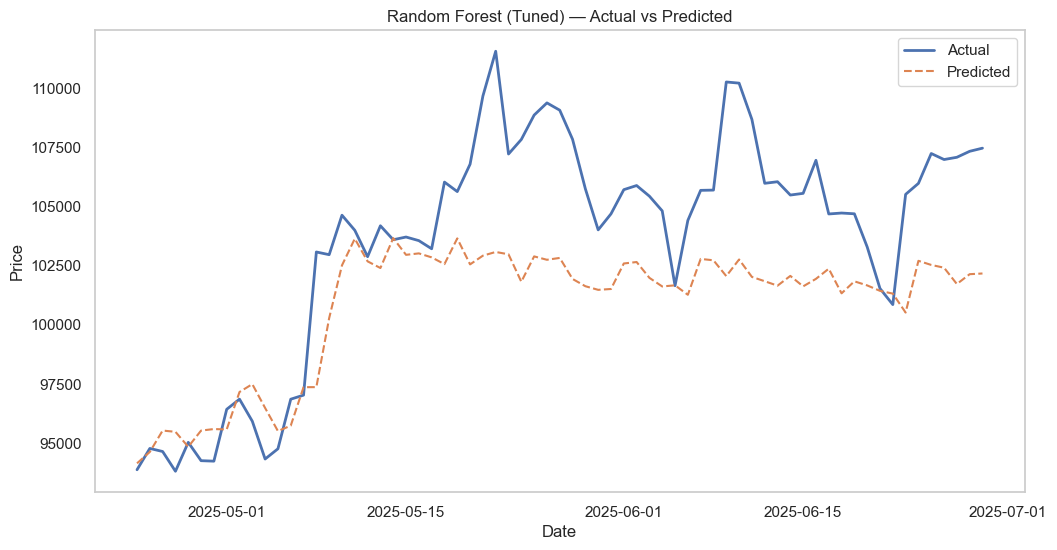

In [7]:
print("Best Random Forest Params:", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_
rf_results = evaluate_model(best_rf, X_test, y_test, "Random Forest (Tuned)")

In [8]:
# 6. GridSearch for XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=tscv, scoring='r2', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

🔍 XGBoost (Tuned) Evaluation:
  R²:  0.3561
  MAE: 3097.68
  MSE: 14772934.33


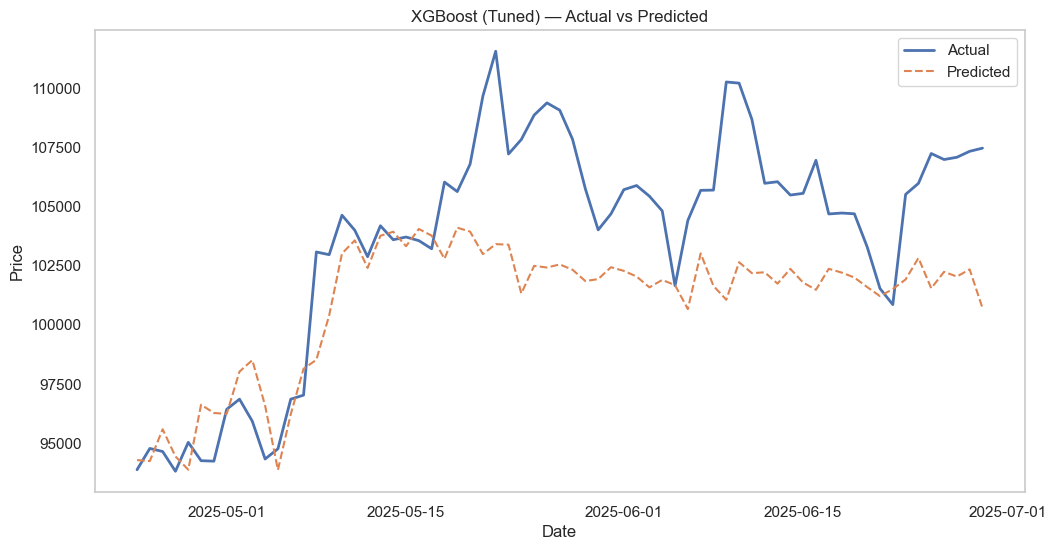

In [9]:
print("Best XGBoost Params:", xgb_grid.best_params_)
best_xgb = xgb_grid.best_estimator_
xgb_results = evaluate_model(best_xgb, X_test, y_test, "XGBoost (Tuned)")

Best Ridge Params: {'alpha': 1.0}

🔍 Ridge Regression (Tuned) Evaluation:
  R²:  0.8454
  MAE: 1457.81
  MSE: 3547327.49


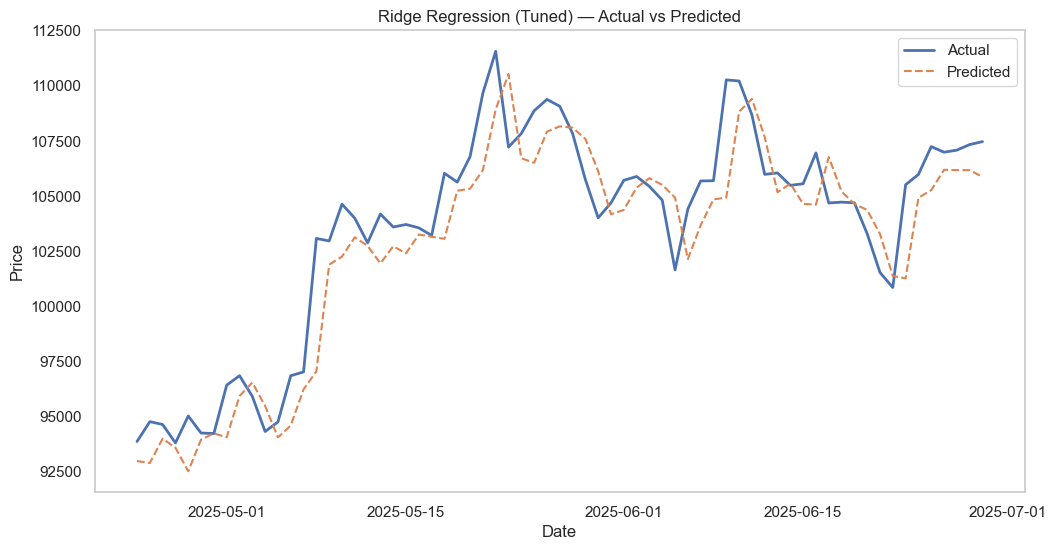

In [16]:
ridge_params = {
    'alpha': [0.01, 0.1, 1.0, 10, 100, 1000]
}

ridge = Ridge()
ridge_grid = GridSearchCV(ridge, ridge_params, cv=tscv, scoring='r2', n_jobs=-1)
ridge_grid.fit(X_train, y_train)

print("Best Ridge Params:", ridge_grid.best_params_)
best_ridge = ridge_grid.best_estimator_
ridge_results = evaluate_model(best_ridge, X_test, y_test, "Ridge Regression (Tuned)")

In [17]:
# 8. Compare Results
results_df = pd.DataFrame([rf_results, xgb_results, ridge_results])
results_df = results_df.sort_values(by='R2', ascending=False)
print("\n📊 Model Comparison:")
display(results_df)


📊 Model Comparison:


,Model,R2,MAE,MSE
2,Ridge Regression (Tuned),0.845382,1457.808303,3.547327e+06
0,Random Forest (Tuned),0.366650,3082.844751,1.453064e+07
1,XGBoost (Tuned),0.356089,3097.675603,1.477293e+07


In [18]:
best_model = max([rf_results, xgb_results, ridge_results], key=lambda x: x['R2'])
if best_model['Model'].startswith("XGBoost"):
    joblib.dump(best_xgb, 'best_model.pkl')
elif best_model['Model'].startswith("Random Forest"):
    joblib.dump(best_rf, 'best_model.pkl')
else:
    joblib.dump(ridge, 'best_model.pkl')

print(f"✅ Best model ({best_model['Model']}) saved as 'best_model.pkl'.")

✅ Best model (Ridge Regression (Tuned)) saved as 'best_model.pkl'.


In [19]:
ridge = Ridge()
param_grid = {'alpha': [0.01, 0.1, 1.0, 10, 100]}
tscv = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(ridge, param_grid, scoring='r2', cv=tscv)
grid.fit(X_train, y_train)

print("Best Ridge alpha:", grid.best_params_)
joblib.dump(grid.best_estimator_, 'best_model.pkl')

Best Ridge alpha: {'alpha': 1.0}


['best_model.pkl']